In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw
import time
import glob
import random
from random import choices
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit import DataStructs
from rdkit.Chem import AllChem

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


In [2]:
## Load hits (or compounds of interest, e.g. non-hits)
total_hits = []
total_smi = []
smi_lib=[]
total_activity = []

for file in glob.glob("./hits.csv"):
    fopen = open(file);
    for line in fopen.readlines():
        y = [value for value in line.split('\n')]
        y = y[0].split(",")
        try: 
            m = Chem.MolFromSmiles(y[0].replace('"',''))
            if m is not None:
                total_hits.append(m)
                total_smi.append(y[0].replace('"',''))
                smi_lib.append(y[1].replace('"','') == "MCULE")
                total_activity.append(y[2])
        except:
            x=1;
    fopen.close()
# 0.8, 0.8

RDKit ERROR: [02:06:04] SMILES Parse Error: syntax error while parsing: SMILES
[02:06:04] SMILES Parse Error: syntax error while parsing: SMILES
RDKit ERROR: [02:06:04] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'
[02:06:04] SMILES Parse Error: Failed parsing SMILES '﻿SMILES' for input: '﻿SMILES'


In [3]:
## Check number of hits
len(total_hits)

3646

In [4]:
# Initialize substructure filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.BRENK)
catalog = FilterCatalog(params)

# Search for PAINS or Brenk alerts
clean = []
cleanidx = []
for i in range(len(total_hits)):
    entry = catalog.GetFirstMatch(total_hits[i])  # Get the first matching PAINS
    if entry is not None:
        x=1
    else:
        # collect indices of molecules without PAINS
        clean.append(total_hits[i])
        cleanidx.append(i)

In [5]:
# Filter based on Tanimono similarity with respect to active compounds in the training set
training_set = '../working_example/train.csv'
tani = []
fopen = open(training_set);
for line in fopen.readlines():
    y = [value for value in line.split('\n')]
    y = y[0].split(",")
    if y[1] == "1":
        m = Chem.MolFromSmiles(y[0])
        if m is not None:
            p = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) # Chem.RDKFingerprint()
            tani.append(p)
fopen.close()

In [6]:
## Check number of active compounds
len(tani)

512

In [7]:
## Calculate min Tanimoto distance for each compound
TANI=[]
for m in clean:
    thisp = AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=2048) 
    maxp = 0
    for p in tani:
        tanimoto = DataStructs.FingerprintSimilarity(thisp,p)
        if tanimoto > maxp:
            maxp = tanimoto
    TANI.append(maxp)
    
# Threshold based on min Tanimoto distance
clean_tani=[];
cleanidx_tani=[]
for i in range(len(TANI)):
    if TANI[i] < 0.5:
        clean_tani.append(clean[i])
        cleanidx_tani.append(cleanidx[i])

In [8]:
# Remove b-lactams and quinolones
clean_tani_bl_fl =[]
clean_tani_bl_fl_idx = []
bls=[]
fls=[]
bl=Chem.MolFromSmiles('C1CNC1=O')
fl=Chem.MolFromSmiles('C1=CC=C2C(=C1)C(=O)C=CN2')
for i in range(len(clean_tani)):
        this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([bl,clean_tani[i]],timeout=1,bondCompare=rdFMCS.BondCompare.CompareOrderExact, completeRingsOnly=True).smartsString);
        if this_MCS.GetNumAtoms() >=4:
            bls.append(i)
            continue
        this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([fl,clean_tani[i]],timeout=1,bondCompare=rdFMCS.BondCompare.CompareOrderExact, completeRingsOnly=True).smartsString);
        if this_MCS.GetNumAtoms() >=11:
            fls.append(i)
            continue
        clean_tani_bl_fl.append(clean_tani[i])
        clean_tani_bl_fl_idx.append(cleanidx_tani[i])
            

In [9]:
## Check number of remaining compounds
len(clean_tani_bl_fl)

1261

In [10]:
## Load rationales to compute scaffolds
rationales=[]
for file in glob.glob("./rationales.csv"):
    fopen = open(file);
    for line in fopen.readlines():
        try:
            y = [value for value in line.split('\n')]
            y = y[0].split(",")
            m = Chem.MolFromSmiles(y[0])
            if m is not None:
                rationales.append(m)
        except:
            x=1
len(rationales)

RDKit ERROR: [02:06:28] SMILES Parse Error: syntax error while parsing: Rationale
RDKit ERROR: [02:06:28] SMILES Parse Error: Failed parsing SMILES '﻿Rationale' for input: '﻿Rationale'
[02:06:28] SMILES Parse Error: syntax error while parsing: Rationale
[02:06:28] SMILES Parse Error: Failed parsing SMILES '﻿Rationale' for input: '﻿Rationale'


186

In [11]:
## Sample scaffolds shared between rationales

### User-defined parameters
N0 = 12 # Low atom threshold in any scaffold
N1 = 16 # High atom threshold in any scaffold
NUM_GROUPS = 5 # Number of different groups to try
NUM_ITER = 1000 # Number of pairs to test in each run


### Main scaffold computation and mining script ###
start_time = time.time()

# Define some lists to hold variables of interest
TOPLIST = []
TOPLIST_IDX = []
ASSOCIATED_NUMs =[ ]
ASSOCIATED_RATIONALES=[]
RATIONALES_LEFT=[]
TRIED = []

for IT in range(NUM_GROUPS):
    toplist = []
    toplist_idx = []
    rationales_associated = []
    associated_nums = []
    associated_rationales = []
    tried = []
    rationales_left = [(rationales[i],i) for i in range(0,len(rationales))] # Keep a tally of the rationales not in any scaffold

    for ITER in range(NUM_ITER):
        yy = random.sample(range(0, len(rationales_left)), 2); # Sample two remaining rationales at random
        if yy in tried:
            continue
        tried.append(yy)
        
        # Calculate scaffold of two rationales
        this_MCS = Chem.MolFromSmarts(rdFMCS.FindMCS([rationales_left[x][0] for x in yy],timeout=1,bondCompare=rdFMCS.BondCompare.CompareOrderExact,completeRingsOnly=True).smartsString);
        this_idx = [rationales_left[x][1] for x in yy];

        if this_MCS.GetNumAtoms() < N0 or this_MCS.GetNumAtoms() > N1:
            continue
        toplist.append(this_MCS) # try out scaffold by tentatively adding it to list
        toplist_idx.append(this_idx)
        associated_nums.append(0)
        associated_rationales.append([])
        rationales_left_update = []

        # Check if other hits contain scaffold using HasSubstructMatch()
        for i in range(len(rationales_left)):
            test_rationale = rationales_left[i][0]
            test_MCS = toplist[-1]
            
            if test_rationale.HasSubstructMatch(test_MCS): 
                associated_nums[-1] = associated_nums[-1] + 1
                associated_rationales[-1].append(rationales_left[i][1])
                rationales_associated.append(rationales_left[i][0])
            else:
                rationales_left_update.append(rationales_left[i])

        if associated_nums[-1] == 0: # useless scaffold
            associated_nums.pop()
            associated_rationales.pop()
            toplist.pop()
            toplist_idx.pop()

        rationales_left = rationales_left_update

    TOPLIST.append(toplist)
    TOPLIST_IDX.append(toplist_idx)
    ASSOCIATED_NUMs.append(associated_nums)
    ASSOCIATED_RATIONALES.append(associated_rationales)
    RATIONALES_LEFT.append(rationales_left)
    TRIED.append(tried)

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.311662197113037 seconds ---


Number of rationales: 186
Number of associated rationales in each group: [2, 5, 2, 5]
Total number of associated rationales in all groups: 14
Number of remaining rationales: 172


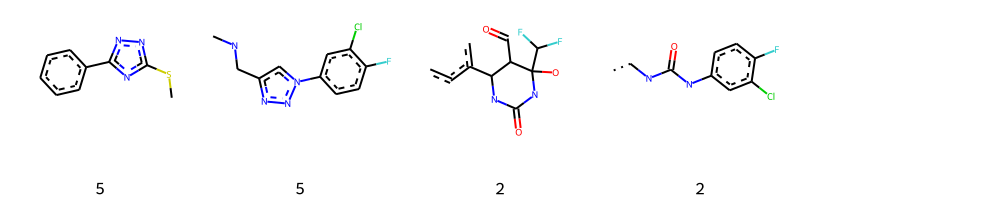

In [12]:
idx = 3 # Number of grouping to show, between 0 and NUM_GROUPS-1

### Show groups ###
toplist = TOPLIST[idx]
toplist_idx = TOPLIST_IDX[idx]
associated_nums = ASSOCIATED_NUMs[idx]
associated_rationales = ASSOCIATED_RATIONALES[idx]
rationales_left = RATIONALES_LEFT[idx]

print("Number of rationales:",len(rationales))  # all rationales
print("Number of associated rationales in each group:", associated_nums)
print("Total number of associated rationales in all groups:", sum(associated_nums)) # associated with scaffold
print("Number of remaining rationales:", len(rationales_left)) # not associated 

redrawTL = []
for x in toplist_idx:
    ss = []
    for i in x:
        ss.append(rationales[i])
    redrawTL.append(Chem.MolFromSmarts(rdFMCS.FindMCS(ss,timeout=1).smartsString))

srt=sorted(zip(associated_nums,range(len(associated_nums))),reverse=True)
Draw.DrawingOptions.atomLabelFontSize =30
img=Draw.MolsToGridImage([redrawTL[ss[1]] for ss in srt], molsPerRow=5,maxMols=1000,legends=[str(ss[0]) for ss in srt], useSVG=True)
img